In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: 999999999999 in;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib inline
import ast
import os
import os.path as osp
from glob import glob

from IPython.display import display, Image, Markdown
from ipywidgets import interact, interactive
import ipywidgets as widgets 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle
from tensorflow.python.summary.summary_iterator import summary_iterator

from attackgraph import settings
import attackgraph.gambit_analysis as gambit_ops
import attackgraph.common.plot_ops as plot_ops

# Set the font to match AAMAS.
import matplotlib
import matplotlib.font_manager as font_manager
font_dirs = ["/Users/max/Library/Fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = "Linux Libertine O"

np.set_printoptions(precision=2)
RESULTS_DIR = settings.get_results_dir()

In [3]:
def parse_metrics_from_event(run_name):    
    # Find event file.
    event_file = max(glob(osp.join(RESULTS_DIR, run_name, "events.*")), key=os.path.getctime)
    print(f"Loading: {event_file}")

    # Collect all of the event file data.
    # We will pre-fix each value with the time-stamp because 
    # the summary data has no ordering guarantees.
    metrics = {}    
    for event in summary_iterator(event_file):
        t = event.step
        
        for value in event.summary.value:
            if value.tag not in metrics:
                metrics[value.tag] = []
            metrics[value.tag] += [(t, value.simple_value)]
        
        if t > 50000:
            break
        
    # Sort each metric by timestep.
    for metric, values in metrics.items():
        values = sorted(values, key=lambda x: x[1])
        values = [x[1] for x in values]
        metrics[metric] = values
    
    return metrics

In [4]:
metrics = [parse_metrics_from_event(f"10_25_distill_{i}") for i in range(5)]

W1111 12:58:59.380965 4502040000 deprecation.py:323] From /usr/local/anaconda3/envs/bgg/lib/python3.7/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_0/events.out.tfevents.1572011072.rldl10
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_1/events.out.tfevents.1572011075.rldl10
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_2/events.out.tfevents.1572011072.rldl10
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_3/events.out.tfevents.1572011073.rldl10
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_4/events.out.tfevents.1572011072.rldl10


In [5]:
metrics[0].keys()

x_lim = 10000

In [6]:
def collect(name):
    """ Collect the metric data. """
    data = []
    for run in metrics:
        data += [np.array(run[name][:x_lim])]
    data = np.array(data)  # [N-Run, T].
    return data

In [7]:
def parse_teacher_rewards(run_name):    
    outfile = osp.join(RESULTS_DIR, run_name, "out.log")
    print(f"Loading: {outfile}")
    with open(outfile, "r") as outfile:
        log = [x.strip() for x in outfile.readlines()]
    
    for line in log:
        if "Teacher reward:" in line:
            tokens = line.split(' ')
            avg = float(tokens[-2].strip(','))
            std = float(tokens[-1])
            return avg, std

In [8]:
targets = [parse_teacher_rewards(f"10_25_distill_{i}") for i in range(5)]
target_mean = np.mean([x[0] for x in targets])
target_std = [x[1] for x in targets]
target_std = np.sqrt(np.sum(np.array(target_std)**2))

Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_0/out.log
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_1/out.log
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_2/out.log
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_3/out.log
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_distill_4/out.log


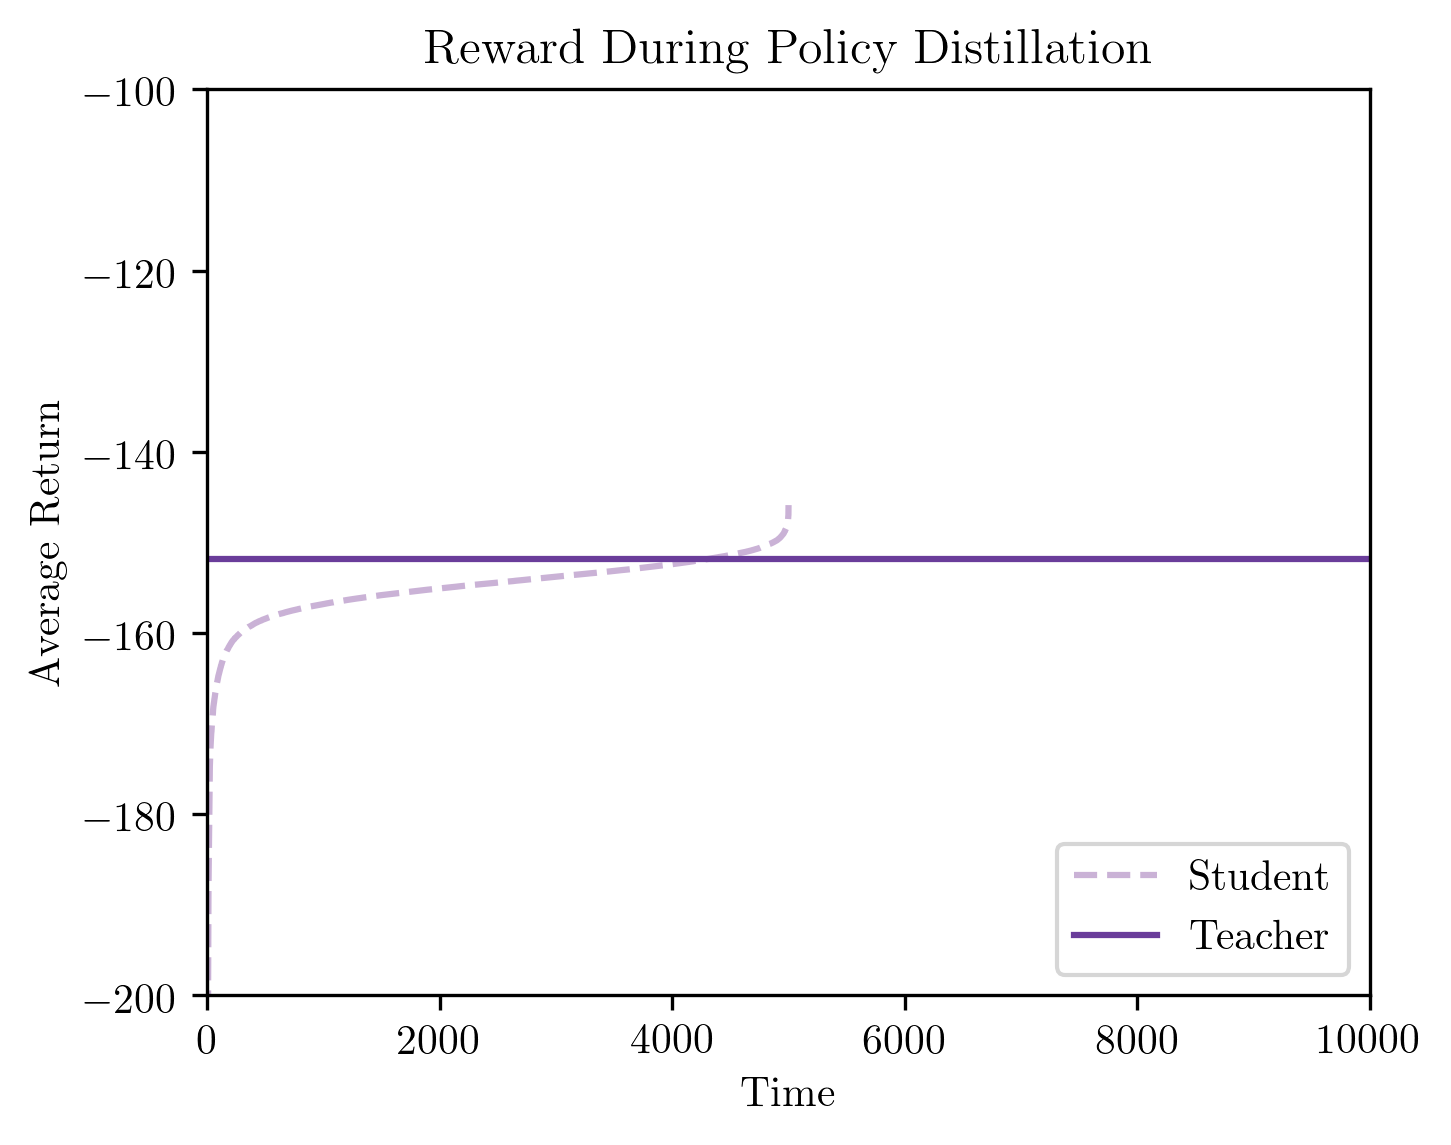

In [10]:
cmap = matplotlib.cm.get_cmap("Paired")
blue = cmap(0.70)
yellow = cmap(0.80)

fig, ax = plt.subplots(figsize=(5,4), dpi=300)

avg = collect("reward/mean")  # [N-Runs, T].
avg = np.mean(avg, axis=0)   # [T].

std = collect("reward/std")    # [N-Runs, T].
std = np.sqrt(np.sum(std**2, axis=0))  # [T].

plt.plot(avg, label="Student", color=blue, linestyle="--")
# plt.fill_between(
#     np.arange(len(avg)),
#     avg - std,
#     avg + std,
#     alpha=0.2)

plt.axhline(y=target_mean, color=yellow, label="Teacher")
# plt.fill_between(
#     np.arange(len(avg)),
#     target_mean - target_std,
#     target_mean + target_std,
#     alpha=0.2)

ax.set_xlim([0, x_lim])
ax.set_ylim([-200, -100])

ax.set_title("Reward During Policy Distillation")
ax.set_ylabel("Average Return")
ax.set_xlabel("Time")

ax.legend(loc="lower right")

plt.show()

In [11]:
target_std

48.411557036425066

In [12]:
std

array([40.27, 40.66, 40.97, ..., 63.94, 65.27, 66.36])

In [13]:
std[4000]

50.13011512532656

In [14]:
avg[4000]

-152.40957336425782

In [16]:
target_mean

-151.80787986341358